Duplicate key in file PosixPath('/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  IPAexGothic')
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


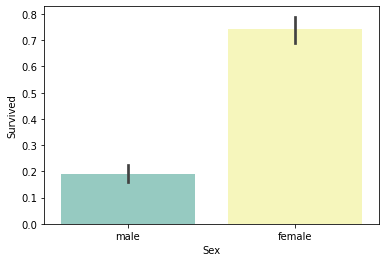

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データセットの読み込み
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

# dfの情報
df.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

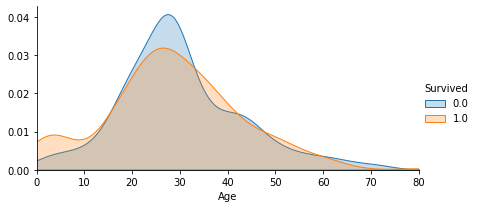

In [2]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

<AxesSubplot:xlabel='Title', ylabel='Survived'>

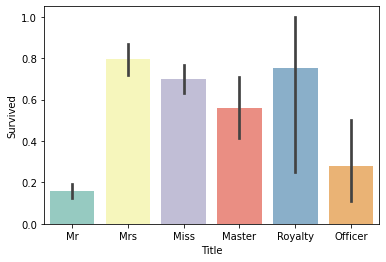

In [3]:
# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

In [4]:
# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

In [5]:
# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

1.000000    113
0.000000     32
0.750000      2
0.333333      1
0.142857      1
0.500000      1
Name: Survived, dtype: int64


In [6]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64


In [7]:
# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Sage', 'Cacic', 'Oreskovic', 'Caram', 'Lefebre', 'Johnston', 'Zabour', 'Barbara', 'Rosblom', 'Skoog', 'Strom', 'Palsson', 'Vander Planke', 'Ford', 'Arnold-Franchi', 'Goodwin', 'Lobb', 'Robins', 'Canavan', 'Boulos', 'Ilmakangas', 'Jussila', 'Turpin', 'Elias', 'Danbom', 'Rice', 'Bourke', 'Attalah', 'Panula', 'Olsson', 'Lahtinen', 'Van Impe'}
Survived_list =  {'Greenfield', 'Nakid', 'Goldenberg', 'Bradley', 'Daly', 'Duff Gordon', 'Beane', 'McCoy', 'Chambers', 'Moubarek', 'Taylor', 'Kimball', 'Cardeza', 'Jussila', 'Frauenthal', 'Harder', 'Jonsson', 'Frolicher-Stehli', 'Dick', 'Beckwith', 'Bishop'}


In [8]:
# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Sage', 'Cacic', 'Oreskovic', 'Caram', 'Lefebre', 'Johnston', 'Zabour', 'Barbara', 'Rosblom', 'Skoog', 'Strom', 'Palsson', 'Vander Planke', 'Ford', 'Arnold-Franchi', 'Goodwin', 'Lobb', 'Robins', 'Canavan', 'Boulos', 'Ilmakangas', 'Jussila', 'Turpin', 'Elias', 'Danbom', 'Rice', 'Bourke', 'Attalah', 'Panula', 'Olsson', 'Lahtinen', 'Van Impe'}
Survived_list =  {'Greenfield', 'Nakid', 'Goldenberg', 'Bradley', 'Daly', 'Duff Gordon', 'Beane', 'McCoy', 'Chambers', 'Moubarek', 'Taylor', 'Kimball', 'Cardeza', 'Jussila', 'Frauenthal', 'Harder', 'Jonsson', 'Frolicher-Stehli', 'Dick', 'Beckwith', 'Bishop'}


In [9]:
# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

In [10]:
# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

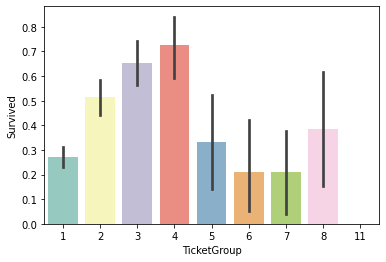

In [11]:
# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

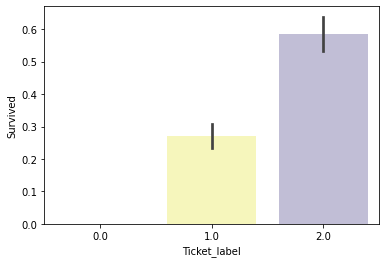

In [12]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

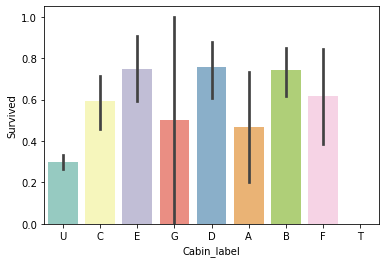

In [13]:
# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

In [14]:
# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 

In [15]:
# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

In [16]:
# ----------- 推定モデル構築 ---------------
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mean_score =  0.8395006242197255
mean_std =  0.049770983038016456


In [17]:
# --------　採用した特徴量 ---------------
# 採用の可否状況
mask= select.get_support()

# 項目のリスト
list_col = list(df.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

# シェイプの確認
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Family_label = True
No5 Ticket_label = True
No6 Sex_female = True
No7 Sex_male = True
No8 Embarked_C = True
No9 Embarked_Q = False
No10 Embarked_S = True
No11 Title_Master = True
No12 Title_Miss = True
No13 Title_Mr = True
No14 Title_Mrs = True
No15 Title_Officer = False
No16 Title_Royalty = True
No17 Cabin_label_A = False
No18 Cabin_label_B = True
No19 Cabin_label_C = True
No20 Cabin_label_D = True
No21 Cabin_label_E = True
No22 Cabin_label_F = True
No23 Cabin_label_G = False
No24 Cabin_label_T = False
No25 Cabin_label_U = True
X.shape=(891, 25), X_selected.shape=(891, 20)


In [18]:
# ----- Submit dataの作成　------- 
PassengerId=test_data['PassengerId']
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("my_submission.csv", index=False)

In [21]:
all_data['Name']

NameError: name 'all_data' is not defined

In [22]:
n = 'Broumd,Mr.Owen Harris'

In [26]:
n.split(',')[1].split('.')[0]

'Mr'

In [31]:
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

KeyError: 'Name'

In [33]:
train = pd.read_csv('train.csv')

In [82]:
train['Surname'] = train['Name'].map(lambda name:name.split(',')[0].strip())


# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
train['FamilyGroup'] = train['Surname'].map(train['Surname'].value_counts())

In [83]:
train['FamilyGroup']

0      2
1      1
2      1
3      2
4      2
      ..
886    1
887    3
888    2
889    1
890    1
Name: FamilyGroup, Length: 891, dtype: int64

In [85]:
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)

In [78]:
Dead_list

{'Arnold-Franchi',
 'Attalah',
 'Barbara',
 'Boulos',
 'Bourke',
 'Cacic',
 'Canavan',
 'Caram',
 'Danbom',
 'Elias',
 'Ford',
 'Goodwin',
 'Ilmakangas',
 'Johnston',
 'Jussila',
 'Lahtinen',
 'Lefebre',
 'Lobb',
 'Olsson',
 'Oreskovic',
 'Palsson',
 'Panula',
 'Rice',
 'Robins',
 'Rosblom',
 'Sage',
 'Skoog',
 'Strom',
 'Turpin',
 'Van Impe',
 'Vander Planke',
 'Zabour'}

In [89]:
print('Dead_list =' ,Dead_list)

Dead_list = {'Sage', 'Cacic', 'Oreskovic', 'Caram', 'Lefebre', 'Johnston', 'Zabour', 'Barbara', 'Rosblom', 'Skoog', 'Strom', 'Palsson', 'Vander Planke', 'Ford', 'Arnold-Franchi', 'Goodwin', 'Lobb', 'Robins', 'Canavan', 'Boulos', 'Ilmakangas', 'Jussila', 'Turpin', 'Elias', 'Danbom', 'Rice', 'Bourke', 'Attalah', 'Panula', 'Olsson', 'Lahtinen', 'Van Impe'}


In [97]:
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),['Sex','Age','Title']] = ['male',28.0,'Mr']

KeyError: 'Surname'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


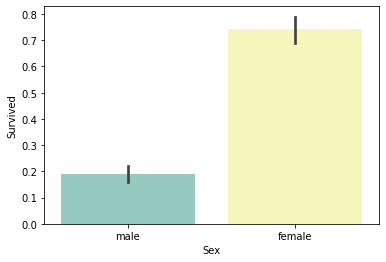

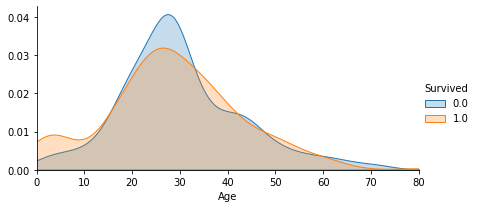

1.000000    113
0.000000     32
0.750000      2
0.333333      1
0.142857      1
0.500000      1
Name: Survived, dtype: int64
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64
Dead_list =  {'Sage', 'Cacic', 'Oreskovic', 'Caram', 'Lefebre', 'Johnston', 'Zabour', 'Barbara', 'Rosblom', 'Skoog', 'Strom', 'Palsson', 'Vander Planke', 'Ford', 'Arnold-Franchi', 'Goodwin', 'Lobb', 'Robins', 'Canavan', 'Boulos', 'Ilmakangas', 'Jussila', 'Turpin', 'Elias', 'Danbom', 'Rice', 'Bourke', 'Attalah', 'Panula', 'Olsson', 'Lahtinen', 'Van Impe'}
Survived_list =  {'Greenfield', 'Nakid', 'Goldenberg', 'Bradley', 'Daly', 'Duff Gordon', 'Beane', 'McCoy', 'Chambers', 'Moubarek', 'Taylor', 'Kimball', 'Cardeza', 'Jussila', 'Frauenthal', 'Harder', 'Jonsson', 'Frolicher-Stehli', 'Dick', 'Beckwith', 'Bishop'}


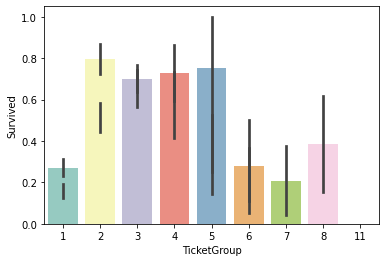

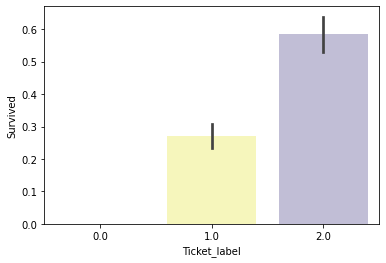

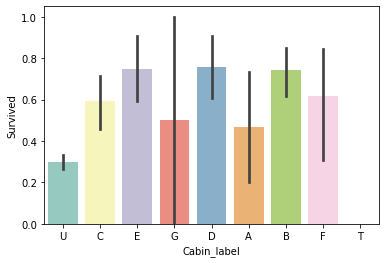

/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mean_score =  0.8395006242197255
mean_std =  0.049770983038016456
No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Family_label = True
No5 Ticket_label = True
No6 Sex_female = True
No7 Sex_male = True
No8 Embarked_C = True
No9 Embarked_Q = False
No10 Embarked_S = True
No11 Title_Master = True
No12 Title_Miss = True
No13 Title_Mr = True
No14 Title_Mrs = True
No15 Title_Officer = False
No16 Title_Royalty = True
No17 Cabin_label_A = False
No18 Cabin_label_B = True
No19 Cabin_label_C = True
No20 Cabin_label_D = True
No21 Cabin_label_E = True
No22 Cabin_label_F = True
No23 Cabin_label_G = False
No24 Cabin_label_T = False
No25 Cabin_label_U = True
X.shape=(891, 25), X_selected.shape=(891, 20)


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データセットの読み込み
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

# dfの情報
df.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 

# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

# ----------- 推定モデル構築 ---------------
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

# --------　採用した特徴量 ---------------
# 採用の可否状況
mask= select.get_support()

# 項目のリスト
list_col = list(df.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

# シェイプの確認
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

# ----- Submit dataの作成　------- 
PassengerId=test_data['PassengerId']
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("my_submission.csv", index=False)


In [101]:
!pip install optuna

In [102]:
# 前処理用ライブラリ
from sklearn.preprocessing import StandardScaler

# パラメータチューニング用ライブラリ Optuna
import optuna
from optuna.samplers import TPESampler
# ログがうるさいのできる
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 機械学習ライブラリ
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score

# Warningがうるさいのできる

In [103]:
class Optimizer:
    def __init__(self, metric, trials=50):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=42)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        if self.metric == 'acc':
            return accuracy_score(y_valid, preds)
        else:
            return f1_score(y_valid, preds)
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params
    
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = xgb.XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        silent=True,
        verbosity = 0,
        random_state=42
    )
    return model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


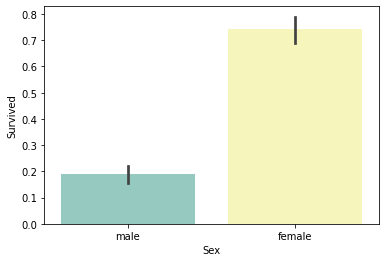

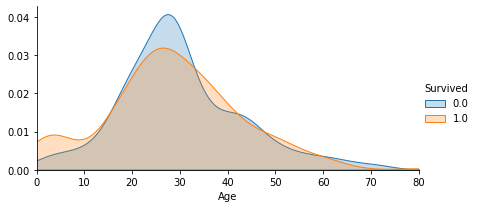

1.000000    113
0.000000     32
0.750000      2
0.333333      1
0.142857      1
0.500000      1
Name: Survived, dtype: int64
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64
Dead_list =  {'Sage', 'Cacic', 'Oreskovic', 'Caram', 'Lefebre', 'Johnston', 'Zabour', 'Barbara', 'Rosblom', 'Skoog', 'Strom', 'Palsson', 'Vander Planke', 'Ford', 'Arnold-Franchi', 'Goodwin', 'Lobb', 'Robins', 'Canavan', 'Boulos', 'Ilmakangas', 'Jussila', 'Turpin', 'Elias', 'Danbom', 'Rice', 'Bourke', 'Attalah', 'Panula', 'Olsson', 'Lahtinen', 'Van Impe'}
Survived_list =  {'Greenfield', 'Nakid', 'Goldenberg', 'Bradley', 'Daly', 'Duff Gordon', 'Beane', 'McCoy', 'Chambers', 'Moubarek', 'Taylor', 'Kimball', 'Cardeza', 'Jussila', 'Frauenthal', 'Harder', 'Jonsson', 'Frolicher-Stehli', 'Dick', 'Beckwith', 'Bishop'}


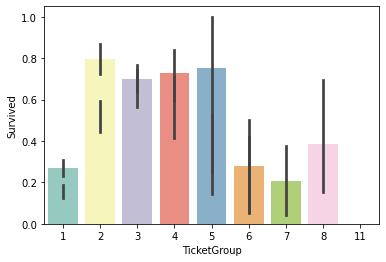

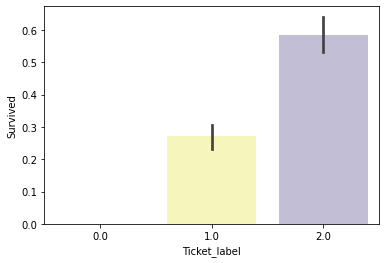

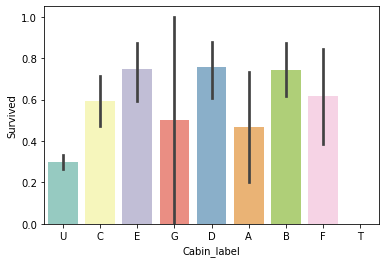

/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-pac

Optimized acc ACC score
XGBoost f1-score:  0.7867298578199052


/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/katoutakaaki/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データセットの読み込み
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

# dfの情報
df.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 

# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

# ----------- 推定モデル構築 ---------------
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 前処理用ライブラリ
from sklearn.preprocessing import StandardScaler

# パラメータチューニング用ライブラリ Optuna
import optuna
from optuna.samplers import TPESampler
# ログがうるさいのできる
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 機械学習ライブラリ
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score
# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)


class Optimizer:
    def __init__(self, metric, trials=50):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=42)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        if self.metric == 'acc':
            return accuracy_score(y_valid, preds)
        else:
            return f1_score(y_valid, preds)
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params
    
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = xgb.XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        silent=True,
        verbosity = 0,
        random_state=42
    )
    return model

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

optimizer = Optimizer('f1')
xgb_f1_params = optimizer.optimize()
xgb_f1_params['random_state'] = 42
xgb_f1 = xgb.XGBClassifier(
    **xgb_f1_params,
)
xgb_f1.fit(X_train, y_train)
preds = xgb_f1.predict(X_valid)

print('Optimized acc ACC score')
print('XGBoost f1-score: ', f1_score(y_valid, preds))

xgb_f1.fit(X,y)
test_Y = xgb_f1.predict(test_x)

sample_submission = pd.read_csv('gender_submission.csv')
sample_submission['Survived'] = test_Y

sample_submission.to_csv('submission_xgb.csv', index=False)